In [118]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
import re
import emoji #dealing with emojis
import contractions

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\xmega\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xmega\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xmega\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [119]:
a_posts_df = pd.read_csv("a_posts_df.csv")
a_comments_df = pd.read_csv("a_comments_df.csv")

a_posts_df.name = "Ath Posts"
a_comments_df.name = "Ath Comments"


## Exploratory Data Analysis

In [120]:
# head of data set
a_posts_df.head()

,post_id,post_title,post_author,post_score,post_url,post_text,num_comments,created_utc
0,i4agbh,The Satanic Temple just announced a Satanic Ri...,FunnyGeekReference23,100847,https://announcement.thesatanictemple.com/rrr-...,NaN,5213,1.596651e+09
1,vjpvsa,"In honor of today's Supreme Court ruling, I ju...",opequan,91882,https://www.reddit.com/r/atheism/comments/vjpv...,Fuck this oppressive religion that has insiste...,3069,1.656081e+09
2,ua3wb5,Florida atheist petitions to ban the Bible in ...,mepper,88065,https://www.miaminewtimes.com/news/broward-man...,NaN,3506,1.650715e+09
3,gm1j1j,"""Since the Bible says not to charge interest o...",mepper,83764,https://twitter.com/DrPsyBuffy/status/10964212...,NaN,1578,1.589809e+09
4,egd37r,"Teenager, 19, kills 'paedophile priest who abu...",[deleted],78030,https://www.dailymail.co.uk/news/article-78302...,NaN,1737,1.577464e+09


In [121]:
a_posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   post_id       300 non-null    object 
 1   post_title    300 non-null    object 
 2   post_author   300 non-null    object 
 3   post_score    300 non-null    int64  
 4   post_url      300 non-null    object 
 5   post_text     64 non-null     object 
 6   num_comments  300 non-null    int64  
 7   created_utc   300 non-null    float64
dtypes: float64(1), int64(2), object(5)
memory usage: 18.9+ KB


In [122]:
a_comments_df.head()

,comment_id,post_id,post_title,comment_author,comment_body,comment_score,comment_parent_id,created_utc
0,g0h93fe,i4agbh,The Satanic Temple just announced a Satanic Ri...,[deleted],The Satanic Temple is a critical watchdog on t...,11341,t3_i4agbh,1.596656e+09
1,g0hb3u3,i4agbh,The Satanic Temple just announced a Satanic Ri...,[deleted],“Prior to receiving any anesthetic or sedation...,5024,t3_i4agbh,1.596657e+09
2,g0gyr8l,i4agbh,The Satanic Temple just announced a Satanic Ri...,[deleted],[deleted],4558,t3_i4agbh,1.596651e+09
3,g0gyol4,i4agbh,The Satanic Temple just announced a Satanic Ri...,MissMarlaMoon,"Once again, Satan is the the logical, ethical ...",2651,t3_i4agbh,1.596651e+09
4,g0h66rl,i4agbh,The Satanic Temple just announced a Satanic Ri...,RealUserForSure,"We did it guys, we can officially say to the c...",2331,t3_i4agbh,1.596655e+09


In [123]:
a_comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14921 entries, 0 to 14920
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   comment_id         14921 non-null  object 
 1   post_id            14921 non-null  object 
 2   post_title         14921 non-null  object 
 3   comment_author     14921 non-null  object 
 4   comment_body       14920 non-null  object 
 5   comment_score      14921 non-null  int64  
 6   comment_parent_id  14921 non-null  object 
 7   created_utc        14921 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 932.7+ KB


In [124]:
def create_edadf(*dataframes):
    eda_df = []
    for df in dataframes:
        eda_df.append({
            "name": df.name,
            "num_rows": df.shape[0],
            "num_cols": df.shape[1],
            "contains_null": df.isnull().any(axis = None)
        })
    return pd.DataFrame(eda_df)
    
p_eda_df = create_edadf(a_posts_df)
c_eda_df = create_edadf(a_comments_df)

In [125]:
p_eda_df

,name,num_rows,num_cols,contains_null
0,Ath Posts,300,8,True


In [126]:
c_eda_df

,name,num_rows,num_cols,contains_null
0,Ath Comments,14921,8,True


## Split Data to Test and Train

In [127]:
#split at this stage to avoid data snooping bias
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
train_p, test_p = train_test_split(a_posts_df, test_size = 0.2, random_state=42)

In [128]:
#filter a_comments_df into train and test based on train_p and test_p
train_c = a_comments_df.loc[a_comments_df["post_id"].isin(train_p["post_id"])]
test_c = a_comments_df.loc[a_comments_df["post_id"].isin(test_p["post_id"])]

In [129]:
#check to see if total equals original length
print(len(train_c) + len(test_c))
print(len(train_p) + len(test_p))

14921
300


In [130]:
posts = train_p.copy()
comments = train_c.copy()

## Preprocess text

In [131]:
posts["post_string"] = posts["post_title"].str.cat(posts["post_title"], sep = " ",na_rep = "")
posts["post_string"].eq("").sum()

np.int64(0)

In [132]:
def preprocess_df(df, text_col = "post_title"):
    #CLEAN TEXT
    processed_texts = []

    #loading stop words and objects from classes
    default_stopwords = set(stopwords.words('english'))
    default_stopwords.add("edit")
    lmtzr = WordNetLemmatizer()

    def clean_text(sentence):
        #return "" if sentence is NaN so no error occurs
        if not isinstance(sentence, str) or sentence.strip() == "":
            return ""
        
        #convert emojis to text    
        sentence = emoji.demojize(sentence)
        #remove https from strings
        sentence = re.sub(r'http\S+','', sentence) 
        #remove new lines
        sentence = re.sub(r'\\n|:|_',' ', sentence)
        #expand contractions
        sentence = contractions.fix(sentence)
        #remove punctuations and lowercase
        sentence = re.sub(r'[^a-zA-Z0-9\s]', '', sentence).lower()


        #tokenize words
        tokens = word_tokenize(sentence)

        final_words = []
        for word in tokens: #for each word in the sentence
            fixed_word = contractions.fix(word) #expand contractions
            if fixed_word not in default_stopwords:
                lemma = lmtzr.lemmatize(fixed_word) #lemmatize words
                final_words.append(lemma) #append the singular lemmatized word to the final_words list

        return ' '.join(final_words) #append the list of words to processed_text
    
    df[text_col] = df[text_col].apply(clean_text)
    return df

In [133]:
posts = preprocess_df(posts, text_col = "post_string")

In [141]:
train_p_string = posts["post_string"]
train_p_string

232    mentioned verse say easier camel pas eye needl...
59     begin dead underdeveloped infant found abandon...
6      breaking isi al qaeda issued statement saying ...
185    supreme court justice brett kavanaugh samuel a...
173    kansa town council vote reinstate god trust de...
                             ...                        
188    religious parent refused take son hospital tho...
71     conservative writer accused drag queen groomin...
106    want add extra 71 billion dollar economy start...
270    christian nurse sacked telling cancer patient ...
102    prolife christian nationalist never miss elect...
Name: post_string, Length: 240, dtype: object

# Visualizations

In [135]:
from sklearn.feature_extraction.text import CountVectorizer

class FreqVisualizer:
    words_ = 0
    counts_ = 0

    def __init__(self, df, text_col):
        self.df = df
        self.text_col = text_col
    
    def visualize_word_freq(self):
        vectorizer = CountVectorizer(stop_words='english')
        X_counts = vectorizer.fit_transform(self.df[self.text_col])

        w_counts = X_counts.toarray().sum(axis = 0)
        word_freq = [(word, w_counts[idx])for word, idx in vectorizer.vocabulary_.items()]
        word_freq = sorted(word_freq, key=lambda x: x[1], reverse = True)

        words = [w[0] for w in word_freq[:30]]
        counts = [w[1] for w in word_freq[:30]]
        fig, ax = plt.subplots()
        ax.barh(words, counts, align = "center")
        ax.invert_yaxis()
        plt.show()

    def create_freq_df(self):
        data = {"Words": self.words_, "Counts": self.counts_}
        word_freq_df = pd.DataFrame(data)
        word_freq_df

    def create_wordcloud(self):
        comment_text = ' '.join(word for word in self.df[self.text_col])
        wordcloud = WordCloud(width = 800, height = 400, background_color= "white").generate(comment_text)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

f_vis_pstring = FreqVisualizer(posts, "post_string")
f_vis_ptitle = FreqVisualizer(posts, "post_title")
f_vis_ptext = FreqVisualizer(posts, "post_text")

In [144]:
print(len(posts[posts["post_text"] != " "]))
print(len(posts["post_title"]))
print(train_p_string.dtype)

240
240
object


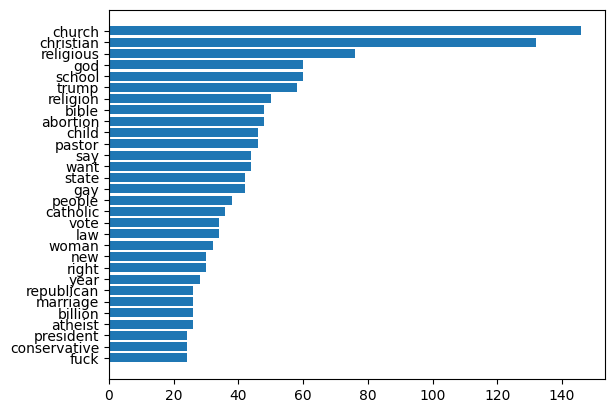

In [137]:
f_vis_pstring.visualize_word_freq()

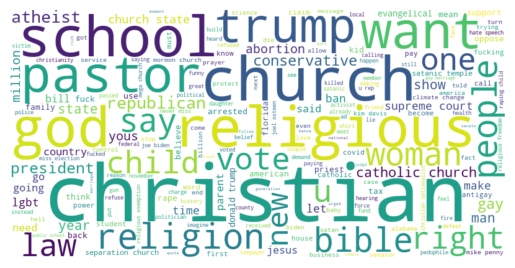

In [138]:
f_vis_pstring.create_wordcloud()

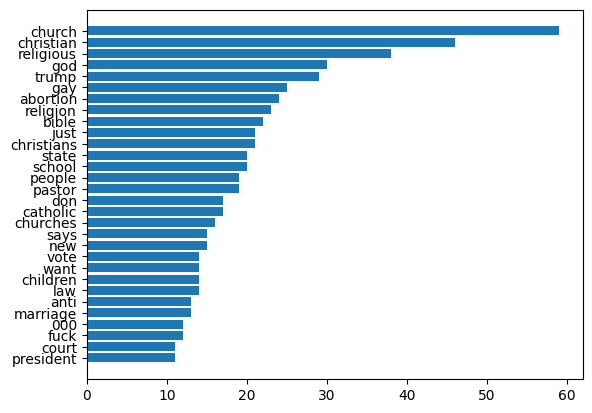

In [139]:
f_vis_ptitle.visualize_word_freq()

In [140]:
f_vis_ptext.visualize_word_freq()

ValueError: np.nan is an invalid document, expected byte or unicode string.

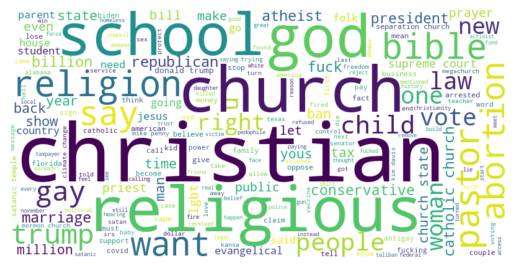

In [ ]:
f_vis_ptitle.create_wordcloud()

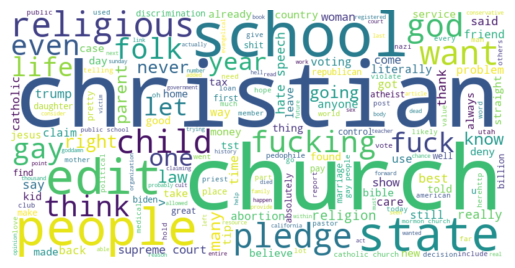

In [ ]:
f_vis_ptext.create_wordcloud()

# Vectorize Text

In [ ]:
vectorizer = TfidfVectorizer(lowercase = True, 
                             max_features=100,
                             max_df = 0.9, #remove words occuring more than x% time in document
                             min_df = 5, #remove words occur less than x times in doc
                             ngram_range = (1,3), #look for one word up to trigrams
                             stop_words= "english")
vectors = vectorizer.fit_transform(posts["post_string"])

In [ ]:
vectors.shape

(240, 100)

In [ ]:
vectorizer.vocabulary_

{'say': np.int64(75),
 'man': np.int64(47),
 'bible': np.int64(7),
 'stop': np.int64(82),
 'woman': np.int64(96),
 'abortion': np.int64(0),
 'vote': np.int64(94),
 'republican': np.int64(70),
 'christian': np.int64(15),
 'separation': np.int64(77),
 'church': np.int64(16),
 'state': np.int64(81),
 'god': np.int64(35),
 'yous': np.int64(99),
 'separation church': np.int64(78),
 'church state': np.int64(17),
 'separation church state': np.int64(79),
 'supreme': np.int64(85),
 'court': np.int64(23),
 'lgbt': np.int64(44),
 'president': np.int64(63),
 'antigay': np.int64(2),
 'hate': np.int64(37),
 'marriage': np.int64(48),
 'supreme court': np.int64(86),
 'said': np.int64(72),
 'religion': np.int64(67),
 'satanic': np.int64(73),
 'temple': np.int64(89),
 'satanic temple': np.int64(74),
 'want': np.int64(95),
 'billion': np.int64(9),
 'american': np.int64(1),
 'know': np.int64(41),
 'believe': np.int64(6),
 'people': np.int64(60),
 'child': np.int64(14),
 'word': np.int64(97),
 'time': np.

In [ ]:
feature_names = vectorizer.get_feature_names_out()
feature_names


array(['abortion', 'american', 'antigay', 'arrested', 'atheist', 'ban',
       'believe', 'bible', 'biden', 'billion', 'business', 'catholic',
       'catholic church', 'change', 'child', 'christian', 'church',
       'church state', 'claim', 'climate', 'conservative', 'country',
       'couple', 'court', 'covid', 'donald', 'donald trump', 'fact',
       'family', 'florida', 'folk', 'freedom', 'fuck', 'fucking', 'gay',
       'god', 'going', 'hate', 'house', 'jesus', 'kid', 'know', 'law',
       'let', 'lgbt', 'like', 'make', 'man', 'marriage', 'mean', 'mike',
       'million', 'money', 'mormon', 'need', 'new', 'oppose', 'parent',
       'pastor', 'penny', 'people', 'power', 'prayer', 'president',
       'priest', 'public', 'rape', 'religion', 'religious', 'rep',
       'republican', 'right', 'said', 'satanic', 'satanic temple', 'say',
       'school', 'separation', 'separation church',
       'separation church state', 'sign', 'state', 'stop', 'student',
       'support', 'supreme', '

In [ ]:
dense = vectors.todense()
denselist = dense.tolist()

all_keywords = []

for description in denselist:
    x = 0
    keywords = []
    for word in description:
        if word > 0:
            keywords.append(feature_names[x])
        x=x+1
    all_keywords.append(keywords)

print(all_keywords) #the relevant words from tf_idf (value is > 0)

[['bible', 'man', 'say', 'stop'], ['abortion', 'christian', 'republican', 'vote', 'woman'], ['church', 'church state', 'god', 'separation', 'separation church', 'separation church state', 'state', 'yous'], ['antigay', 'court', 'hate', 'lgbt', 'marriage', 'president', 'supreme', 'supreme court'], ['god', 'religion', 'said', 'satanic', 'satanic temple', 'temple', 'vote'], ['billion', 'church', 'want'], ['american', 'believe', 'god', 'know', 'people', 'religion', 'want'], ['child'], ['god', 'religion'], ['child', 'court', 'god', 'supreme', 'supreme court', 'time', 'word'], ['atheist', 'christian'], ['christian', 'oppose', 'rep', 'say'], ['change', 'climate', 'fucking', 'jesus', 'need', 'pastor'], ['freedom', 'new', 'religious'], ['ban', 'conservative', 'marriage', 'religious', 'republican', 'vote', 'want'], ['antigay', 'church', 'church state', 'house', 'mean', 'religious', 'state'], ['church', 'religious'], [], ['church', 'house', 'people'], ['abortion', 'biden', 'catholic', 'catholic ch

## KMeans Cluster Terms

In [ ]:
from sklearn.cluster import KMeans

true_k = 5
model = KMeans(n_clusters = true_k,
               init = "k-means++",
               max_iter = 100,
               n_init = 1)

model.fit(vectors)


,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",5
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",1
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",100
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",None
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


In [ ]:
order_centroids = model.cluster_centers_.argsort()[:,::-1]
terms = vectorizer.get_feature_names_out()

In [ ]:
cluster_d = {}

for i in range(true_k):
    cluster_i = []
    for ind in order_centroids[i, :10]:
        cluster_i.append(f"{terms[ind]} ")
        cluster_d[f"Cluster {i}"] = cluster_i
    print()


cluster_df = pd.DataFrame(cluster_d)

In [ ]:
cluster_df

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,church,bible,trump,christian,god
1,religious,law,satanic,trump,religion
2,pastor,abortion,donald,year,religious
3,child,say,donald trump,bible,pastor
4,vote,going,abortion,republican,yous
5,want,school,satanic temple,country,parent
6,gay,new,oppose,yous,people
7,catholic,ban,temple,say,tell
8,billion,religious,million,school,child
9,school,penny,freedom,gay,school


In [ ]:
from sklearn.decomposition import PCA
kmean_indices = model.fit_predict(vectors)
kmean_indices

array([0, 1, 0, 1, 1, 3, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0, 3, 1, 3, 2, 1, 4,
       3, 1, 4, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0, 0, 4, 2, 3, 0, 1, 2, 3,
       1, 0, 0, 3, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 1, 4, 4, 3, 2, 1, 4, 2,
       1, 3, 3, 2, 1, 1, 4, 4, 1, 2, 4, 1, 3, 4, 1, 1, 3, 3, 2, 4, 2, 3,
       1, 3, 1, 3, 2, 1, 1, 4, 1, 1, 3, 1, 1, 4, 4, 1, 1, 0, 4, 2, 2, 4,
       1, 2, 4, 1, 1, 1, 3, 2, 1, 0, 4, 1, 3, 1, 1, 4, 2, 1, 2, 4, 3, 1,
       1, 2, 3, 3, 2, 0, 4, 4, 2, 2, 1, 2, 1, 2, 1, 1, 1, 3, 1, 1, 1, 0,
       1, 4, 0, 1, 4, 2, 1, 1, 1, 0, 1, 1, 3, 1, 1, 0, 4, 1, 3, 1, 4, 1,
       1, 1, 1, 2, 1, 1, 1, 4, 1, 0, 1, 1, 4, 4, 4, 2, 3, 1, 3, 0, 3, 1,
       1, 1, 3, 1, 1, 1, 4, 1, 3, 2, 2, 1, 3, 1, 1, 1, 0, 1, 1, 4, 2, 1,
       1, 4, 1, 3, 1, 0, 2, 1, 3, 0, 3, 1, 1, 1, 1, 1, 2, 3, 1, 2],
      dtype=int32)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(vectors.toarray())
colors = ["r","b","c","y","m"]

x_axis = [o[0] for o in scatter_plot_points]
y_axis  = [o[1] for o in scatter_plot_points]

fig, ax = plt.subplots(figsize = (50,50))
ax.scatter(x_axis, y_axis, c = [colors[d] for d in kmean_indices])

for i, txt in enumerate(posts["post_title"]):
    ax.annotate(txt[0:5], (x_axis[i], y_axis[i]))



In [ ]:
posts["post_title"]

232    mentioned verse say easier camel pas eye needl...
59     begin dead underdeveloped infant found abandon...
6      breaking isi al qaeda issued statement saying ...
185    supreme court justice brett kavanaugh samuel a...
173    kansa town council vote reinstate god trust de...
                             ...                        
188    religious parent refused take son hospital tho...
71     conservative writer accused drag queen groomin...
106    want add extra 71 billion dollar economy start...
270    christian nurse sacked telling cancer patient ...
102    prolife christian nationalist never miss elect...
Name: post_title, Length: 240, dtype: object

# LDA Topic Modeling

In [ ]:
#https://github.com/keitazoumana/lda-tutorial/blob/main/topic-modeling-with-lda.ipynb
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
p_title = posts["post_string"]
#turning text into bag of words
vectorizer = CountVectorizer(max_df = 0.95, min_df = 3, stop_words="english")
dtm = vectorizer.fit_transform(posts["post_string"])
dtm #document term matrix has 240 documents and 311 words?

KeyError: 'post_string'

In [ ]:
LDA_model = LatentDirichletAllocation(n_components= n_topics,
                                      max_iter=30,
                                      random_state = 42)

LDA_model.fit(dtm)

,"n_components n_components: int, default=10Number of topics... versionchanged:: 0.19 ``n_topics`` was renamed to ``n_components``",10
,"doc_topic_prior doc_topic_prior: float, default=NonePrior of document topic distribution `theta`. If the value is None,defaults to `1 / n_components`.In [1]_, this is called `alpha`.",None
,"topic_word_prior topic_word_prior: float, default=NonePrior of topic word distribution `beta`. If the value is None, defaultsto `1 / n_components`.In [1]_, this is called `eta`.",None
,"learning_method learning_method: {'batch', 'online'}, default='batch'Method used to update `_component`. Only used in :meth:`fit` method.In general, if the data size is large, the online update will be muchfaster than the batch update.Valid options:- 'batch': Batch variational Bayes method. Use all training data in each EM update. Old `components_` will be overwritten in each iteration.- 'online': Online variational Bayes method. In each EM update, use mini-batch of training data to update the ``components_`` variable incrementally. The learning rate is controlled by the ``learning_decay`` and the ``learning_offset`` parameters... versionchanged:: 0.20 The default learning method is now ``""batch""``.",'batch'
,"learning_decay learning_decay: float, default=0.7It is a parameter that control learning rate in the online learningmethod. The value should be set between (0.5, 1.0] to guaranteeasymptotic convergence. When the value is 0.0 and batch_size is``n_samples``, the update method is same as batch learning. In theliterature, this is called kappa.",0.7
,"learning_offset learning_offset: float, default=10.0A (positive) parameter that downweights early iterations in onlinelearning. It should be greater than 1.0. In the literature, this iscalled tau_0.",10.0
,"max_iter max_iter: int, default=10The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the :meth:`fit` method, and not the:meth:`partial_fit` method.",30
,"batch_size batch_size: int, default=128Number of documents to use in each EM iteration. Only used in onlinelearning.",128
,"evaluate_every evaluate_every: int, default=-1How often to evaluate perplexity. Only used in `fit` method.set it to 0 or negative number to not evaluate perplexity intraining at all. Evaluating perplexity can help you check convergencein training process, but it will also increase total training time.Evaluating perplexity in every iteration might increase training timeup to two-fold.",-1
,"total_samples total_samples: int, default=1e6Total number of documents. Only used in the :meth:`partial_fit` method.",1000000.0
,"perp_tol perp_tol: float, default=1e-1Perplexity tolerance. Only used when ``evaluate_every`` is greater than 0.",0.1


In [ ]:
import random
for i in range(15):
    random_word_ID = random.randint(0,300)
    print(vectorizer.get_feature_names_out()[random_word_ID])


porn
trying
homeless
sex
ll
hearing
12
atheist
hate
god
america
arrested
science
florida
said


In [ ]:
a_topic = LDA_model.components_[0] #get first topic from 7 topics that we set in NB_TOPICS

In [ ]:
top_10_word_indices = a_topic.argsort()[-10:] #get top 10 words for the first topic

for i in top_10_word_indices:
    print(vectorizer.get_feature_names_out()[i])

trying
sex
marriage
million
loses
science
oppose
donald
christian
trump


In [ ]:
for i, topic in enumerate(LDA_model.components_):
    print("Top {} words for topic #{}".format(10,i))
    print([vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]])
    print("\n")

Top 10 words for topic #0
['trying', 'sex', 'marriage', 'million', 'loses', 'science', 'oppose', 'donald', 'christian', 'trump']


Top 10 words for topic #1
['kids', 'president', 'biden', 'let', 'pastor', 'covid', 'school', 'children', 'catholic', 'church']


Top 10 words for topic #2
['woman', 'religion', 'god', 'man', 'billion', 'pence', 'mike', 'stock', 'just', 'church']


Top 10 words for topic #3
['away', 'freedom', 'people', 'religion', 'temple', 'want', 'satanic', 'christian', 'abortion', 'religious']


Top 10 words for topic #4
['christian', 'says', 'mentioned', 'texas', 'abortion', 'don', 'schools', 'atheist', 'god', 'bible']


Top 10 words for topic #5
['good', 'christian', 'christians', 'miss', 'hate', 'speech', 'god', 'election', 'vote', 'fuck']


Top 10 words for topic #6
['county', 'start', 'want', 'tax', 'dollars', 'taxing', 'exemptions', 'religious', 'billion', 'churches']


Top 10 words for topic #7
['separation', 'lgbt', 'christians', 'law', 'new', 'religious', 'state

In [ ]:
final_topics = LDA_model.transform(dtm)
final_topics.shape

(240, 10)

In [ ]:
posts_labeled = posts.copy()
posts_labeled["Topic"] = final_topics.argmax(axis = 1)
posts_labeled.head() 

,post_id,post_title,post_author,post_score,post_url,post_text,num_comments,created_utc,post_string,Topic
232,k3via9,I mentioned the verse that says it’s easier fo...,relevantlife,27676,https://www.reddit.com/r/atheism/comments/k3vi...,I’m talking about Matthew 19:24 in which Jesus...,1886,1.606742e+09,mentioned verse say easier camel pas eye needl...,9
59,xpvahe,"And it begins. Dead, underdeveloped infant fou...",relevantlife,44761,https://www.reddit.com/r/atheism/comments/xpva...,https://newschannel9.com/news/local/dead-infan...,1356,1.664319e+09,begin dead underdeveloped infant found abandon...,5
6,ixmk3f,Breaking: ISIS and Al Qaeda just issued a stat...,relevantlife,73638,https://twitter.com/bryandawsonusa/status/1308...,NaN,526,1.600778e+09,breaking isi al qaeda issued statement saying ...,7
185,dsyab6,Supreme Court Justices Brett Kavanaugh and Sam...,mepper,30456,https://www.newsweek.com/supreme-court-justice...,NaN,1118,1.573136e+09,supreme court justice brett kavanaugh samuel a...,7
173,urlo3i,"Kansas town's council votes to reinstate ""In G...",mepper,31431,https://onlysky.media/hemant-mehta/rural-kansa...,NaN,1042,1.652792e+09,kansa town council vote reinstate god trust de...,3


(array([26., 33., 24., 25., 20., 17., 11., 39., 21., 24.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

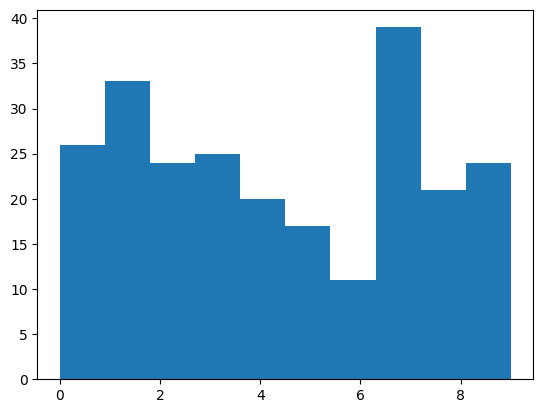

In [ ]:
plt.hist(posts_labeled["Topic"])

In [ ]:
posts_labeled["post_string"][posts_labeled["Topic"] == 7]

6      breaking isi al qaeda issued statement saying ...
185    supreme court justice brett kavanaugh samuel a...
186    word god appears 41 time alabama supreme court...
282    white house streaming antigay religious servic...
101    republican north dakota state senator ray holm...
16     u rep adam kinzinger ril hit back fellow repub...
179    huge separation church state win u supreme cou...
147    religious school get public tax money follow l...
183    church flying spaghetti monster allows pastafa...
181    u christian greater threat america isi u chris...
248    new speaker house mike johnson united state bi...
55     7year old boy killed courtappointed guardian p...
139    36 mega church alabama casino ended paying fun...
120    pastor greg locke shut church service social d...
127    christian tn cheering gov say sign law making ...
223    conservative child ready see gay marriage tv a...
280    nazi pagan atheist fox news lying nazi christi...
159    meet new secretary educa

## Label sentiment score for comments

In [ ]:
def preprocess_comment(df, text_col = "comment_body"):
    #CLEAN TEXT
    processed_texts = []
    lmtzr = WordNetLemmatizer()

    def clean_text(sentence):
        #return "" if sentence is NaN so no error occurs
        if not isinstance(sentence, str) or sentence.strip() == "":
            return ""
        
        #convert emojis to text    
        sentence = emoji.demojize(sentence)
        #remove https from strings
        sentence = re.sub(r'http\S+','', sentence) 
        #remove new lines
        sentence = re.sub(r'\\n|:|_',' ', sentence)
        #expand contractions
        sentence = contractions.fix(sentence)
        #remove punctuations and lowercase
        sentence = re.sub(r'[^a-zA-Z0-9\s]', '', sentence).lower()
        return(sentence)

        #tokenize words
        """
        tokens = word_tokenize(sentence)

        final_words = []
        for word in tokens: #for each word in the sentence
            fixed_word = contractions.fix(word) #expand contractions
            lemma = lmtzr.lemmatize(fixed_word) #lemmatize words
            final_words.append(lemma) #append the singular lemmatized word to the final_words list

        return ' '.join(final_words) #append the list of words to processed_text
        """
    
    df[text_col] = df[text_col].apply(clean_text)
    return df

In [ ]:
comments_test = preprocess_comment(comments, text_col = "comment_body")
comments_test["comment_body"]

0        the satanic temple is a critical watchdog on t...
1        prior to receiving any anesthetic or sedation ...
2                                                  deleted
3        once again satan is the the logical ethical ch...
4        we did it guys we can officially say to the co...
                               ...                        
14916    ted cruz is a major idiot if you have the inte...
14917    lol these people are such a joke\n\ncannot bel...
14918    no ted your an asshole first and your an aardv...
14919    did not kennedy have to reasure the public tha...
14920                the pandering is strong with this one
Name: comment_body, Length: 11958, dtype: object

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def score_sentiment(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)

    


In [ ]:
sid_obj = SentimentIntensityAnalyzer()
comments_test['compound'] = [sid_obj.polarity_scores(x)['compound'] for x in comments_test["comment_body"]]

In [ ]:
comments_test.to_csv("comment_compound_sent.csv", index = False)

## Prepare for ML

In [ ]:
test_p

,post_id,post_title,post_author,post_score,post_url,post_text,num_comments,created_utc
203,b8xp8w,Tennessee bill would make it legal for adoptio...,relevantlife,29136,https://www.tennessean.com/story/news/2019/04/...,NaN,712,1.554297e+09
266,cs0wq2,Newly elected St. Louis County Councilwoman Ke...,mepper,26226,https://www.stltoday.com/opinion/editorial/edi...,NaN,699,1.566133e+09
152,a0xbt9,"6,000 to 10,000 Churches are dying each year i...",blownawayaway,33254,https://factsandtrends.net/2018/01/16/hope-for...,NaN,937,1.543342e+09
9,vkcw9h,The Satanic Temple: Our members can assert a r...,mepper,66858,https://cdn.shopify.com/s/files/1/0428/0465/fi...,NaN,1480,1.656156e+09
233,5u56tg,“Among the 27 fatal terror attacks inflicted i...,McDowdy,27645,http://www.slate.com/articles/news_and_politic...,NaN,1952,1.487131e+09
226,8rcug6,"""Dear people citing The Bible: It’s a cool boo...",freeth1nker,28169,https://twitter.com/pattonoswalt/status/100751...,NaN,692,1.529084e+09
196,cc4fwc,Egyptian Atheist Youtuber Sherif Gaber is on t...,[deleted],29856,https://twitter.com/Mr_SherifGaber/status/1149...,NaN,1150,1.562896e+09
109,fj2xt1,My parents’ church isn’t closing for COVID-19....,[deleted],36370,https://www.reddit.com/r/atheism/comments/fj2x...,Thankfully my dad is a sensible Christian (som...,1440,1.584286e+09
5,zzr4qa,"Pope Benedict XVI, a former member of Hitler Y...",shrigay,75166,https://edition.cnn.com/2022/12/31/europe/pope...,NaN,1324,1.672483e+09
175,k6nguc,California megachurch pastor dies days after a...,fyhr100,31357,https://religionnews.com/2020/12/03/california...,NaN,1071,1.607097e+09
